# Autoregression
A regression model, such as linear regression, models an output value based on a linear combination of input values.

For example:

yhat = b0 + b1*X1
Where yhat is the prediction, b0 and b1 are coefficients found by optimizing the model on training data, and X is an input value.This technique can be used on time series where input variables are taken as observations at previous time steps, called lag variables.For example, we can predict the value for the next time step (t+1) given the observations at the last two time steps (t-1 and t-2). As a regression model, this would look as follows:

X(t+1) = b0 + b1*X(t-1) + b2*X(t-2)

Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).

In [1]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas.plotting import lag_plot
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

series = read_csv('daily_temperature.csv', header=0, index_col=0)
print(series.head())
series.plot()
pyplot.show()

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


<Figure size 640x480 with 1 Axes>

# Quick Check for Autocorrelation
There is a quick, visual check that we can do to see if there is an autocorrelation in our time series dataset. We can plot the observation at the previous time step (t-1) with the observation at the next time step (t+1) as a scatter plot. This could be done manually by first creating a lag version of the time series dataset and using a built-in scatter plot function in the Pandas library. But there is an easier way. Pandas provides a built-in plot to do exactly this, called the lag_plot() function. Below is an example of creating a lag plot of the Minimum Daily Temperatures dataset.

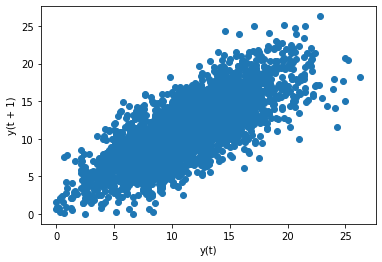

In [2]:
lag_plot(series, lag = 1)
pyplot.show()

We can see a large ball of observations along a diagonal line of the plot. It clearly shows a relationship or some correlation. This process could be repeated for any other lagged observation, such as if we wanted to review the relationship with the last 7 days or with the same day last month or last year.

# Pearson Correlation
Another quick check that we can do is to directly calculate the correlation between the observation and the lag variable.

We can use a statistical test like the Pearson correlation coefficient. This produces a number to summarize how correlated two variables are between -1 (negatively correlated) and +1 (positively correlated) with small values close to zero indicating low correlation and high values above 0.5 or below -0.5 showing high correlation. Correlation can be calculated easily using the corr() function on the DataFrame of the lagged dataset. The example below creates a lagged version of the Minimum Daily Temperatures dataset and calculates a correlation matrix of each column with other columns, including itself.

In [3]:
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.77487
t+1  0.77487  1.00000


This is a good confirmation for the plot above. It shows a strong positive correlation (0.77) between the observation and the lag=1 value.

# Autocorrelation Function (ACF)
We can plot the correlation coefficient for each lag variable. The statsmodels library also provides a version of the plot in the plot_acf() function as a line plot. In this example, we limit the lag variables evaluated to 31 for readability.

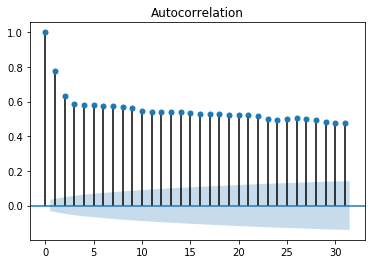

In [4]:
plot_acf(series, lags=31)
pyplot.show()

# Persistence Model
Let’s say that we want to develop a model to predict the last 7 days of minimum temperatures in the dataset given all prior observations.

The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 7 observations in the dataset assigned to the test set as “unseen” data that we wish to predict.

The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next day. This means that we are not making a 7-day forecast, but 7 1-day forecasts.

Test MSE: 3.423


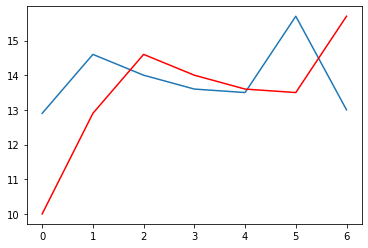

In [13]:
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

The expected values for the next 7 days are plotted (blue) compared to the predictions from the model (red).

# Autoregression Model
An autoregression model is a linear regression model that uses lagged variables as input variables. We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class. We can use this model by first creating the model AutoReg() and then calling fit() to train it on our dataset. This returns an AutoRegResults object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 7-day forecast, which is different from the persistence example above.

The complete example is listed below.

Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test RMSE: 1.225


C:\Users\abhui\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


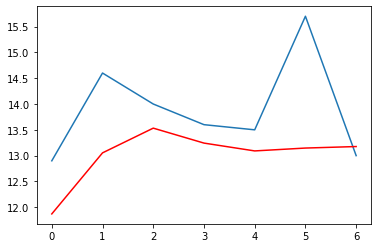

In [8]:
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

#print predictions
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

A plot of the expected (blue) vs the predicted values (red) is made. The forecast does look pretty good (about 1 degree Celsius out each day), with big deviation on day 5.

The statsmodels API does not make it easy to update the model as new observations become available. One way would be to re-train the AutoReg model each day as new observations become available, and that may be a valid approach, if not computationally expensive.

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 29 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.

The coefficients are provided in an array with the intercept term followed by the coefficients for each lag variable starting at t-1 to t-n. We simply need to use them in the right order on the history of observations, as follows:

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test RMSE: 1.204


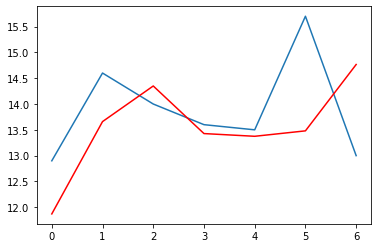

In [6]:
# walk forward over time steps in test
window = 29
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]

predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()